# Credit Default Risk Prediction
# Part 3. Modeling

**Table of Contents**<a id='toc0_'></a>    
- 1. [Introduction    ](#toc1_)    
- 2. [Notebook Preparation    ](#toc2_)    
- 3. [Various Base Models    ](#toc3_)    
- 4. [Various Feature Sets    ](#toc4_)    
  - 4.1. [Original and Engineered Features from Application Table  ](#toc4_1_)    
  - 4.2. [Engineered Features from All Tables  ](#toc4_2_)    
  - 4.3. [Reduced Feature Subsets  ](#toc4_3_)    
- 5. [Tuning Model Parameters    ](#toc5_)    
- 6. [Model Performance    ](#toc6_)    
  - 6.1. [Validation Set    ](#toc6_1_)    
  - 6.2. [Test Set    ](#toc6_2_)    
  - 6.3. [Model Interpretation ](#toc6_3_)    
- 7. [Model Deployment ](#toc7_)    
- 8. [Recommendations](#toc8_)    
- 9. [Suggestions for Improvements](#toc9_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

Note that the links in the above table of contents do not work on GitHub or Google Colab. In Google Colab, please use its embedded table of contents.

## 1. <a id='toc1_'></a>Introduction     [&#8593;](#toc0_)

This notebook is dedicated to developing a credit default risk prediction model. First, different model architectures are tried out with base features only from the main application table, without including engineered features. Then, the best performing architectures are tested with different combinations of features, including engineered features and their subsets. The parameters of the best performing architecture are fine-tuned, and finally, its generalization performance on the test set is measured using ML metrics. Of course, to better represent the business interest, the decision threshold is tuned to maximize total gain. A simple prototype of the possible default risk prediction application is deployed.

## 2. <a id='toc2_'></a>Notebook Preparation     [&#8593;](#toc0_)

Import libraries for model testing, performance visualization and parameter tuning. Set parameters for display.

In [1]:
from typing import List, Any
import pandas as pd
import polars as pl
import numpy as np
from numpy import argmax
from polars import col as c
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import TargetEncoder, StandardScaler
from feature_engine.selection import DropFeatures
from helper_functions import credit_data_utils, custom_model
from helper_functions.feature_utils import get_drop_multicollinear
from sklearn.linear_model import (
    LogisticRegression,
    PassiveAggressiveClassifier,
    RidgeClassifier,
    SGDClassifier,
)
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import (
    QuadraticDiscriminantAnalysis,
    LinearDiscriminantAnalysis,
)
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import lightgbm as lgbm
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklego.meta import Thresholder
import shap
import optuna
from optuna import Trial
import joblib
import warnings


custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    "axes.labelsize": 11,
    "figure.figsize": (6, 4),
    "figure.autolayout": True,
    "patch.edgecolor": "w",
    "patch.linewidth": 0.5,
    "legend.frameon": False,
    "axes.titlesize": "large",
    "figure.titlesize": "large",
}
sns.set_theme(style="whitegrid", rc=custom_params)
pd.set_option("display.precision", 3, "display.max_rows", None)
warnings.filterwarnings("ignore")

Function to split data based on application ID.

In [2]:
def split_data(
    data: pl.DataFrame, idx_train: pd.Series, idx_test: pd.Series
) -> List:
    """Function to split data based on application ID and return pandas df."""
    data_train = data.filter(c.SK_ID_CURR.is_in(idx_train)).to_pandas()
    data_test = data.filter(c.SK_ID_CURR.is_in(idx_test)).to_pandas()
    X_train = data_train.drop(columns=["SK_ID_CURR", "TARGET"])
    X_test = data_test.drop(columns=["SK_ID_CURR", "TARGET"])
    y_train = data_train["TARGET"]
    y_test = data_test["TARGET"]
    return [X_train, X_test, y_train, y_test]

Load saved training and testing indices.

In [3]:
idx_train = pl.read_csv("idx_train.csv", has_header=False).to_series()
idx_test = pl.read_csv("idx_test.csv", has_header=False).to_series()

## 3. <a id='toc3_'></a>Various Base Models     [&#8593;](#toc0_)

First, features from the main application table, selected based on initial exploratory data analysis, are used to test various ML architectures with default parameters.

In [4]:
columns = [
    "SK_ID_CURR",
    "TARGET",
    "NAME_CONTRACT_TYPE",
    "CODE_GENDER",
    "AMT_GOODS_PRICE",
    "NAME_INCOME_TYPE",
    "NAME_EDUCATION_TYPE",
    "NAME_FAMILY_STATUS",
    "NAME_HOUSING_TYPE",
    "REGION_POPULATION_RELATIVE",
    "DAYS_BIRTH",
    "DAYS_EMPLOYED",
    "DAYS_REGISTRATION",
    "DAYS_ID_PUBLISH",
    "OWN_CAR_AGE",
    "FLAG_WORK_PHONE",
    "FLAG_PHONE",
    "OCCUPATION_TYPE",
    "REGION_RATING_CLIENT_W_CITY",
    "HOUR_APPR_PROCESS_START",
    "REG_CITY_NOT_LIVE_CITY",
    "REG_CITY_NOT_WORK_CITY",
    "ORGANIZATION_TYPE",
    "EXT_SOURCE_1",
    "EXT_SOURCE_2",
    "EXT_SOURCE_3",
    "APARTMENTS_AVG",
    "YEARS_BUILD_AVG",
    "FLOORSMAX_AVG",
    "COMMONAREA_AVG",
    "DEF_60_CNT_SOCIAL_CIRCLE",
    "DAYS_LAST_PHONE_CHANGE",
    "FLAG_DOCUMENT_3",
    "AMT_INCOME_TOTAL",
    "AMT_ANNUITY",
    "AMT_CREDIT",
    "CNT_CHILDREN",
    "CNT_FAM_MEMBERS",
]
appls = (
    pl.read_csv("./data/application_train.csv")
    .pipe(credit_data_utils.initial_application_cleaning)
    .select(columns)
    .pipe(credit_data_utils.reduce_memory_usage_pl)
)
appls = appls.with_columns(
    CODE_GENDER=pl.when(c.CODE_GENDER == "M")
    .then(pl.lit(0))
    .when(c.CODE_GENDER == "F")
    .then(pl.lit(1))
    .otherwise(pl.lit(None))
    .cast(pl.Float32),
    DAYS_EMPLOYED=c.DAYS_EMPLOYED.fill_null(0),
    OWN_CAR_AGE=c.OWN_CAR_AGE.fill_null(0),
)
for col in appls.columns:
    column = appls[col]
    if ("NAME_" in col) | ("_TYPE" in col) | ("WALLSMATERIAL_" in col):
        appls = appls.with_columns(column.fill_null("XNA").alias(col))
appls_join = {
    "other": appls.select(["SK_ID_CURR", "TARGET"]),
    "on": "SK_ID_CURR",
    "how": "left",
}
appls_train = appls.filter(c.SK_ID_CURR.is_in(idx_train))
appls_test = appls.filter(c.SK_ID_CURR.is_in(idx_test))
del appls

Size before cleaning: 351.98 MB
Initial number of columns: 122
Size after cleaning: 270.50 MB
Number of columns left: 94
Size before memory reduction: 125.80 MB
Initial data types Counter({Int64: 17, Float64: 12, String: 8, Enum(categories=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23']): 1})
Size after memory reduction: 36.63 MB
Final data types Counter({Float32: 12, Categorical(ordering='physical'): 8, Int8: 7, Int32: 6, Int16: 4, Enum(categories=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23']): 1})


Similarly as in feature engineering part, data is preprocessed to impute missing values and encode categorical columns. 

In [5]:
appls_preprocess_pipe = ColumnTransformer(
    [
        (
            "int_imp",
            SimpleImputer(strategy="most_frequent"),
            make_column_selector(pattern="FLAG_|CODE_|REG_|REGION_RATING_"),
        ),
        (
            "cont_imp",
            SimpleImputer(strategy="median"),
            make_column_selector(pattern="DAYS_|AMT_|CNT_|_AVG|EXT_|_RELATIV"),
        ),
        (
            "target_enc",
            TargetEncoder(target_type="binary", random_state=42),
            make_column_selector(dtype_include="category"),
        ),
    ],
    remainder="passthrough",
    verbose_feature_names_out=False,
).set_output(transform="pandas")

Thirty one feature from the main application table as selected through exploratory data analysis are used to compare various model architectures with default parameters. Comparison is done on the training set using 5-fold cross-validation. If possible, internal weighting scheme is used to address class imbalance.

In [6]:
refit = False
if refit:
    drop = [
        "AMT_INCOME_TOTAL",
        "AMT_ANNUITY",
        "AMT_CREDIT",
        "CNT_CHILDREN",
        "CNT_FAM_MEMBERS",
    ]
    X_train, _, y_train, _ = split_data(appls_train.drop(drop), idx_train, [])
    counter = Counter(y_train)
    scale_pos_weight = counter[0] / counter[1]
    models = [
        GaussianNB(),
        LogisticRegression(random_state=42, class_weight="balanced"),
        RidgeClassifier(random_state=42, class_weight="balanced"),
        PassiveAggressiveClassifier(
            random_state=42, class_weight="balanced", n_jobs=-1
        ),
        LinearDiscriminantAnalysis(),
        QuadraticDiscriminantAnalysis(),
        KNeighborsClassifier(),
        LinearSVC(random_state=42, class_weight="balanced"),
        SGDClassifier(random_state=42, class_weight="balanced", n_jobs=-1),
        DecisionTreeClassifier(random_state=42, class_weight="balanced"),
        RandomForestClassifier(
            random_state=42, class_weight="balanced", n_jobs=-1
        ),
        ExtraTreesClassifier(
            random_state=42, class_weight="balanced", n_jobs=-1
        ),
        LGBMClassifier(
            verbose=-1, random_state=42, class_weight="balanced", n_jobs=-1
        ),
        XGBClassifier(
            verbose=-1,
            random_state=42,
            scale_pos_weight=scale_pos_weight,
            n_jobs=-1,
        ),
    ]
    model_pipes = [
        Pipeline(
            steps=[
                ("preprocess", appls_preprocess_pipe),
                ("scaler", StandardScaler()),
                ("model", model),
            ]
        )
        for model in models
    ]
    model_names = [model.__str__().split("(")[0] for model in models]
    res_df = custom_model.cv_score_binary_classifiers(
        model_names,
        model_pipes,
        fold=5,
        X=X_train,
        y=y_train,
    )
    res_df.to_csv("./output/base_models_score.csv")
else:
    res_df = pd.read_csv("./output/base_models_score.csv", index_col=0)
    display(
        res_df.sort_values("AUC", ascending=False)
        .style.highlight_max(color="green", axis=0)
        .format(precision=3)
    )

,AUC,Average Precision,Recall,Precision,Accuracy,Balanced Accuracy,F1,F-beta,MCC,Time
LGBMClassifier,0.751,0.233,0.667,0.165,0.701,0.685,0.265,0.415,0.216,12.258
RidgeClassifier,0.739,0.212,0.667,0.157,0.685,0.677,0.255,0.405,0.203,7.220
LogisticRegression,0.739,0.212,0.670,0.157,0.683,0.677,0.254,0.405,0.203,7.885
LinearSVC,0.739,0.212,0.656,0.159,0.693,0.676,0.256,0.404,0.204,479.415
LinearDiscriminantAnalysis,0.738,0.212,0.017,0.443,0.919,0.508,0.033,0.021,0.074,8.865
XGBClassifier,0.736,0.220,0.609,0.170,0.728,0.674,0.265,0.401,0.209,11.098
SGDClassifier,0.729,0.200,0.657,0.152,0.676,0.667,0.247,0.394,0.191,17.119
RandomForestClassifier,0.724,0.199,0.006,0.506,0.919,0.503,0.012,0.007,0.048,74.722
ExtraTreesClassifier,0.719,0.201,0.002,0.532,0.919,0.501,0.004,0.003,0.029,61.300
QuadraticDiscriminantAnalysis,0.693,0.160,0.282,0.194,0.848,0.590,0.230,0.259,0.152,8.693


LGBM and logistic regression classifiers are identified as top models for further investigation. A threshold-agnostic metric of ROC AUC is used is used to evaluate how good at ranking predictions the model is. So the base AUC score is 0.751.

## 4. <a id='toc4_'></a>Various Feature Sets     [&#8593;](#toc0_)

### 4.1. <a id='toc4_1_'></a>Original and Engineered Features from Application Table   [&#8593;](#toc0_)

The top two model architectures are tested out with 38 features from the main application table including engineered features.

In [7]:
appls_full_pipe = joblib.load("./job_files/appls_full_pipe.joblib")
refit = False
if refit:
    lgbm_pipe = Pipeline(
        steps=[
            ("preprocess", appls_full_pipe),
            (
                "model",
                LGBMClassifier(
                    verbose=-1,
                    random_state=42,
                    class_weight="balanced",
                    n_jobs=-1,
                ),
            ),
        ]
    )
    lr_pipe = Pipeline(
        steps=[
            ("preprocess", appls_full_pipe),
            ("scaler", StandardScaler()),
            (
                "model",
                LogisticRegression(random_state=42, class_weight="balanced"),
            ),
        ]
    )
    X_train, _, y_train, _ = split_data(appls_train, idx_train, [])
    res_df = custom_model.cv_score_binary_classifiers(
        ["LGBMClassifier", "LogisticRegression"],
        [lgbm_pipe, lr_pipe],
        fold=5,
        X=X_train,
        y=y_train,
    )
    res_df.to_csv("./output/appls_eng_score.csv")
else:
    res_df = pd.read_csv("./output/appls_eng_score.csv", index_col=0)
    display(
        res_df.sort_values("AUC", ascending=False)
        .style.highlight_max(color="green", axis=0)
        .format(precision=3)
    )

,AUC,Average Precision,Recall,Precision,Accuracy,Balanced Accuracy,F1,F-beta,MCC,Time
LGBMClassifier,0.765,0.246,0.685,0.171,0.707,0.697,0.274,0.428,0.230,560.124
LogisticRegression,0.758,0.233,0.656,0.174,0.721,0.691,0.275,0.422,0.227,536.528


AUC for LGMB classifier increases from 0.751 to 0.765 after introducing engineered features from the main application table. AUC also increases for the logistic regression classifier from 0.739 to 0.758. This increase is even higher because engineered features better uncover relationships between features and target. Of course, the time needed for the full pipe to be executed substantially increases because one of the engineered features relies on calculating closest neighbors. 

### 4.2. <a id='toc4_2_'></a>Engineered Features from All Tables   [&#8593;](#toc0_)

Features engineered using data from all other tables are joined to main application table.

In [8]:
bureau_agg = (
    pl.read_csv("./data_agg/bureau_agg.csv")
    .pipe(credit_data_utils.reduce_memory_usage_pl, False)
    .rename(lambda col: "BUREAUT_" + col if col != "SK_ID_CURR" else col)
)
prev_agg = (
    pl.read_csv("./data_agg/prev_agg.csv")
    .pipe(credit_data_utils.reduce_memory_usage_pl, False)
    .rename(lambda col: "PREVT_" + col if col != "SK_ID_CURR" else col)
)
pos_cash_agg = (
    pl.read_csv("./data_agg/pos_cash_agg.csv")
    .pipe(credit_data_utils.reduce_memory_usage_pl, False)
    .rename(lambda col: "POST_" + col if col != "SK_ID_CURR" else col)
)
card_agg = (
    pl.read_csv("./data_agg/card_agg.csv")
    .pipe(credit_data_utils.reduce_memory_usage_pl, False)
    .rename(lambda col: "CARDT_" + col if col != "SK_ID_CURR" else col)
)
inst_agg = (
    pl.read_csv("./data_agg/inst_agg.csv")
    .pipe(credit_data_utils.reduce_memory_usage_pl, False)
    .rename(lambda col: "INSTT_" + col if col != "SK_ID_CURR" else col)
)
full_df_train = (
    appls_train.join(other=bureau_agg, on="SK_ID_CURR", how="left")
    .join(other=prev_agg, on="SK_ID_CURR", how="left")
    .join(other=pos_cash_agg, on="SK_ID_CURR", how="left")
    .join(other=card_agg, on="SK_ID_CURR", how="left")
    .join(other=inst_agg, on="SK_ID_CURR", how="left")
)
full_df_test = (
    appls_test.join(other=bureau_agg, on="SK_ID_CURR", how="left")
    .join(other=prev_agg, on="SK_ID_CURR", how="left")
    .join(other=pos_cash_agg, on="SK_ID_CURR", how="left")
    .join(other=card_agg, on="SK_ID_CURR", how="left")
    .join(other=inst_agg, on="SK_ID_CURR", how="left")
)
del bureau_agg, prev_agg, pos_cash_agg, card_agg, inst_agg

Preprocessing pipe is slightly modified because features engineered on previous applications also include categorical features which need to be encoded.

In [9]:
enc_pipe = ColumnTransformer(
    [
        (
            "target_enc",
            TargetEncoder(target_type="binary", random_state=42),
            make_column_selector(dtype_include="category"),
        ),
    ],
    remainder="passthrough",
    verbose_feature_names_out=False,
).set_output(transform="pandas")
preprocess_ct = ColumnTransformer(
    [
        (
            "appls_preprocess",
            appls_full_pipe,
            make_column_selector(
                pattern="^(?!BUREAUT_|PREVT_|POST_|CARDT_|INSTT_).*$"
            ),
        ),
        (
            "prev_appls_enc",
            enc_pipe,
            make_column_selector(pattern="^PREVT_.*"),
        ),
    ],
    remainder="passthrough",
    verbose_feature_names_out=False,
).set_output(transform="pandas")

Before performing cross-validation, multicollinearity is addressed again to account for the fact that features from different tables can still be correlated.

In [10]:
refit = False
if refit:
    full_df_preprocess_pipe = Pipeline(
        steps=[
            ("preprocess", preprocess_ct),
            ("nan_imp", SimpleImputer(strategy="constant")),
        ]
    ).set_output(transform="pandas")
    X_train, _, y_train, _ = split_data(full_df_train, idx_train, [])
    X_train = full_df_preprocess_pipe.fit_transform(X_train, y_train)
    drop_corr_full = get_drop_multicollinear(
        X_train, y_train, "drop_corr_full", refit=refit
    )
else:
    drop_corr_full = np.loadtxt(
        "./output/drop_corr_full.csv", dtype=str
    ).tolist()
    print(
        "Number of quasi-constant and multicollinear aggregated features to"
        f" drop: {len(drop_corr_full)}"
    )

Number of quasi-constant and multicollinear aggregated features to drop: 77


Missing values in aggregated features are left untreated while applying LGBM classifier and imputed with 0 while applying logistic regression. In total, 663 features are used for predictions.

In [11]:
refit = False
if refit:
    lgbm_pipe = Pipeline(
        steps=[
            ("preprocess", preprocess_ct),
            ("drop_corr", DropFeatures(drop_corr_full)),
            (
                "model",
                LGBMClassifier(
                    verbose=-1,
                    random_state=42,
                    class_weight="balanced",
                    n_jobs=-1,
                ),
            ),
        ]
    )
    lr_pipe = Pipeline(
        steps=[
            ("preprocess", preprocess_ct),
            ("drop_corr", DropFeatures(drop_corr_full)),
            ("scaler", StandardScaler()),
            ("nan_imp", SimpleImputer(strategy="constant")),
            (
                "model",
                LogisticRegression(random_state=42, class_weight="balanced"),
            ),
        ]
    )
    X_train, _, y_train, _ = split_data(full_df_train, idx_train, [])
    res_df = custom_model.cv_score_binary_classifiers(
        ["LGBMClassifier", "LogisticRegression"],
        [lgbm_pipe, lr_pipe],
        fold=5,
        X=X_train,
        y=y_train,
    )
    res_df.to_csv("./output/full_df_score.csv")
else:
    res_df = pd.read_csv("./output/full_df_score.csv", index_col=0)
    display(
        res_df.sort_values("AUC", ascending=False)
        .style.highlight_max(color="green", axis=0)
        .format(precision=3)
    )

,AUC,Average Precision,Recall,Precision,Accuracy,Balanced Accuracy,F1,F-beta,MCC,Time
LGBMClassifier,0.789,0.279,0.695,0.189,0.734,0.716,0.297,0.452,0.258,663.953
LogisticRegression,0.778,0.257,0.684,0.183,0.727,0.708,0.289,0.442,0.247,649.535


After including engineered features from other tables, AUC for LGMB classifier increases from 0.765 to 0.789. AUC also increases for the logistic regression classifier from 0.758 to 0.778. 

### 4.3. <a id='toc4_3_'></a>Reduced Feature Subsets   [&#8593;](#toc0_)

A part of training data is used for validation to obtain SHAP values from LGBM classifier with default parameters

In [12]:
temp = full_df_train.select(["SK_ID_CURR", "TARGET"]).to_pandas()
idx_train_sub, idx_val, _, _ = train_test_split(
    temp["SK_ID_CURR"],
    temp["TARGET"],
    test_size=0.2,
    random_state=42,
    stratify=temp["TARGET"],
)
print(f"Train size: {len(idx_train_sub)} instances")
print(f"Validation size: {len(idx_val)} instances")

Train size: 196806 instances
Validation size: 49202 instances


Performance of LGBM and logistic regression classifiers with top 100, 50, 20 and 10 features is evaluated using 5-fold cross-validation.

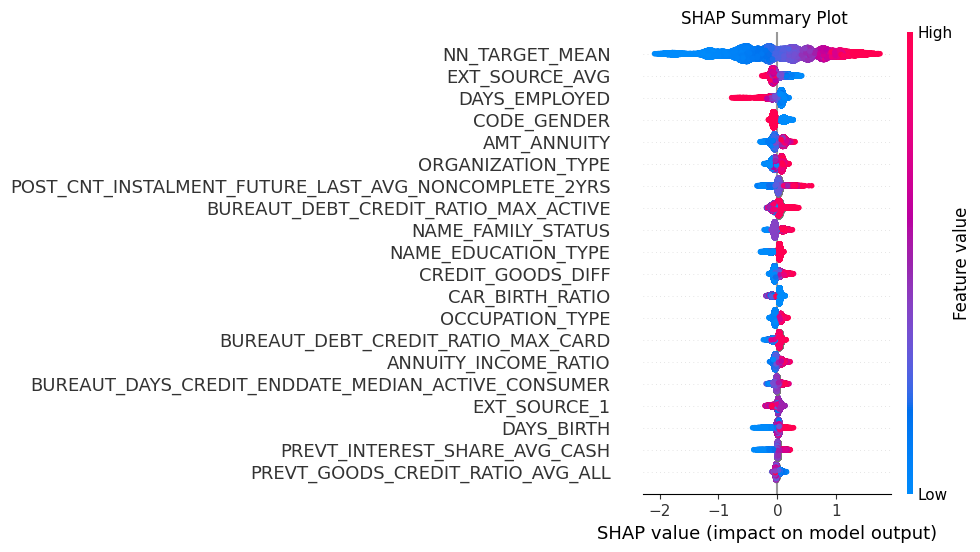


Model performance with top 100 features:


,AUC,Average Precision,Recall,Precision,Accuracy,Balanced Accuracy,F1,F-beta,MCC,Time
LGBMClassifier,0.789,0.278,0.704,0.188,0.730,0.718,0.296,0.454,0.259,613.170
LogisticRegression,0.775,0.251,0.684,0.180,0.724,0.705,0.285,0.439,0.243,580.897



Model performance with top 50 features:


,AUC,Average Precision,Recall,Precision,Accuracy,Balanced Accuracy,F1,F-beta,MCC,Time
LGBMClassifier,0.787,0.274,0.702,0.185,0.727,0.715,0.293,0.451,0.255,612.820
LogisticRegression,0.766,0.240,0.669,0.177,0.721,0.698,0.279,0.430,0.234,568.914



Model performance with top 20 features:


,AUC,Average Precision,Recall,Precision,Accuracy,Balanced Accuracy,F1,F-beta,MCC,Time
LGBMClassifier,0.773,0.255,0.696,0.175,0.710,0.704,0.280,0.436,0.238,564.059
LogisticRegression,0.761,0.235,0.662,0.175,0.721,0.694,0.277,0.426,0.230,566.656



Model performance with top 10 features:


,AUC,Average Precision,Recall,Precision,Accuracy,Balanced Accuracy,F1,F-beta,MCC,Time
LGBMClassifier,0.761,0.237,0.694,0.166,0.694,0.694,0.268,0.425,0.224,583.964
LogisticRegression,0.755,0.226,0.649,0.174,0.723,0.689,0.274,0.420,0.225,586.534


In [13]:
def select_top_features(df: pd.DataFrame, n: int) -> List:
    """Function to select top n features. Returns the list of features to drop."""
    drop_unimportant = (
        df.sort_values("importance", ascending=False)
        .tail(len(df) - n)["name"]
        .to_list()
    )
    return drop_unimportant


refit = False
if refit:
    full_df_preprocess_pipe = Pipeline(
        steps=[
            ("preprocess", preprocess_ct),
            ("drop_corr", DropFeatures(drop_corr_full)),
        ]
    ).set_output(transform="pandas")
    X_train_sub, X_val, y_train_sub, y_val = split_data(
        full_df_train, idx_train_sub, idx_val
    )
    X_train_sub = full_df_preprocess_pipe.fit_transform(
        X_train_sub, y_train_sub
    )
    X_val = full_df_preprocess_pipe.transform(X_val)
    lgbm_explain = LGBMClassifier(
        verbose=-1, random_state=42, class_weight="balanced", n_jobs=-1
    )
    lgbm_explain.fit(X_train_sub, y_train_sub)
    explainer = shap.TreeExplainer(lgbm_explain)
    shap_values = explainer.shap_values(X_val)
    feature_importance = pd.DataFrame(
        list(zip(X_val.columns, sum(np.abs(shap_values).mean(axis=0)))),
        columns=["name", "importance"],
    )
    feature_importance.to_csv("./output/shap_values.csv")
    shap.summary_plot(
        shap_values[1],
        X_val,
        show=False,
        plot_size=(4, 6),
    )
    plt.title("SHAP Summary Plot ")
    plt.savefig("./output/SHAP_untuned.png", bbox_inches="tight")
    plt.show()
    for num in ["100", "50", "20", "10"]:
        drop_by_shap = select_top_features(feature_importance, int(num))
        lgbm_pipe = Pipeline(
            steps=[
                ("preprocess", preprocess_ct),
                ("drop_corr", DropFeatures(drop_corr_full)),
                ("drop_unimportant", DropFeatures(drop_by_shap)),
                (
                    "model",
                    LGBMClassifier(
                        verbose=-1,
                        random_state=42,
                        class_weight="balanced",
                        n_jobs=-1,
                    ),
                ),
            ]
        )
        lr_pipe = Pipeline(
            steps=[
                ("preprocess", preprocess_ct),
                ("drop_corr", DropFeatures(drop_corr_full)),
                ("drop_unimportant", DropFeatures(drop_by_shap)),
                ("scaler", StandardScaler()),
                ("nan_imp", SimpleImputer(strategy="constant")),
                (
                    "model",
                    LogisticRegression(
                        random_state=42, class_weight="balanced"
                    ),
                ),
            ]
        )
        X_train, _, y_train, _ = split_data(full_df_train, idx_train, [])
        res_df = custom_model.cv_score_binary_classifiers(
            ["LGBMClassifier", "LogisticRegression"],
            [lgbm_pipe, lr_pipe],
            fold=5,
            X=X_train,
            y=y_train,
        )
        res_df.to_csv(f"./output/feat{num}_score.csv")
else:
    feature_importance = pd.read_csv("./output/shap_values.csv")
    display(Image("./output/SHAP_untuned.png"))
for num in ["100", "50", "20", "10"]:
    res_df = pd.read_csv(f"./output/feat{num}_score.csv", index_col=0)
    print(f"\nModel performance with top {num} features:")
    display(
        res_df.sort_values("AUC", ascending=False)
        .style.highlight_max(color="green", axis=0)
        .format(precision=3)
    )

Selecting the top 100 features only slightly affected the performance of the LGBM classifier. Further reducing the number of features to the top 50 affected the performance a bit more. Drastically reducing the number of features to the top 20 or 10 had a more detrimental effect. In all these cases, the performance of the logistic regression classifier dropped even further. It is possible that the selection of features favored the LGBM classifier. However, it is also true that the LGBM classifier can capture nonlinear relationships in data better. Compared to logistic regression, LGBM has another advantage: it can deal with missing values internally. Thus, this algorithm is selected for fine-tuning using the top 100 features.

## 5. <a id='toc5_'></a>Tuning Model Parameters     [&#8593;](#toc0_)

Final preprocessing pipeline is defined to prepare data for LGBM parameter tuning.

In [14]:
drop_by_shap = select_top_features(feature_importance, 100)
preprocess_pipe = Pipeline(
    steps=[
        ("preprocess", preprocess_ct),
        ("drop_corr", DropFeatures(drop_corr_full)),
        ("drop_unimportant", DropFeatures(drop_by_shap)),
    ]
).set_output(transform="pandas")
display(preprocess_pipe)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('appls_preprocess',
                                                  Pipeline(steps=[('preprocessing',
                                                                   ColumnTransformer(remainder='passthrough',
                                                                                     transformers=[('int_imp',
                                                                                                    SimpleImputer(strategy='most_frequent'),
                                                                                                    <sklearn.compose._column_transformer.make_column_selector object at 0x000001BBA0E56E10>),
                                                                                                   ('cont_imp',
                                                                                                    Simple...
                                                'PREVT_NAME_YIELD_GROUP_LAST',
                                                'INSTT_PAYMENT_INSTALMENT_RATIO_LAST_MIN_ALL',
                                                'BUREAUT_DEBT_CREDIT_RATIO_AVG_ACTIVE_CONSUMER',
                                                'CARDT_BALANCE_LIMIT_RATIO_MIN_2MTHS',
                                                'PREVT_AMT_APPLICATION_AVG_CONSUMER',
                                                'INSTT_AMT_PAYMENT_SUM_MEDIAN_NONCARD',
                                                'CARDT_PAYMENT_INST_RATIO_MEDIAN_2YRS',
                                                'PREVT_GOODS_CREDIT_RATIO_AVG_APPROVED',
                                                'PREVT_GOODS_CREDIT_RATIO_MIN_ALL', ...]))])

To save time, parameters are tuned using validation dataset. Data is preprocessed before tuning. This approach allows to stop model training if performance of the model on the validation set stops improving and, thus, estimate the number of trees needed for the classifier.

In [15]:
refit = False
if refit:
    X_train_sub, X_val, y_train_sub, y_val = split_data(
        full_df_train, idx_train_sub, idx_val
    )
    X_train_sub = preprocess_pipe.fit_transform(X_train_sub, y_train_sub)
    X_val = preprocess_pipe.transform(X_val)
    X_train_sub.to_csv("./data_preprocessed/X_train_sub_preprocessed.csv")
    y_train_sub.to_csv("./data_preprocessed/y_train_sub.csv")
    X_val.to_csv("./data_preprocessed/X_val_preprocessed.csv")
    y_val.to_csv("./data_preprocessed/y_val.csv")
else:
    X_train_sub = pd.read_csv(
        "./data_preprocessed/X_train_sub_preprocessed.csv", index_col=0
    )
    y_train_sub = pd.read_csv(
        "./data_preprocessed/y_train_sub.csv", index_col=0
    )
    X_val = pd.read_csv(
        "./data_preprocessed/X_val_preprocessed.csv", index_col=0
    )
    y_val = pd.read_csv("./data_preprocessed/y_val.csv", index_col=0)

A function is defined to easer instantiate classifier with the best parameter combiantion.

In [16]:
def instantiate_lightgbm(trial: Trial) -> LGBMClassifier:
    params = {
        "verbosity": -1,
        "n_jobs": 4,
        "random_state": 42,
        "objective": "binary",
        "boosting_type": "gbdt",
        "metric": "auc",
        "class_weight": "balanced",
        "n_estimators": 10000,
        "early_stopping_rounds": 100,
        "learning_rate": trial.suggest_float(
            "learning_rate", 0.01, 0.3, step=0.01
        ),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 100, step=0.1),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 100, step=0.1),
        "subsample": trial.suggest_float("subsample", 0.4, 1.0, step=0.1),
        "subsample_freq": 1,
        "colsample_bytree": trial.suggest_float(
            "colsample_bytree", 0.4, 1.0, step=0.1
        ),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "min_child_weight": trial.suggest_float(
            "min_child_weight", 0.01, 1000
        ),
        "min_split_gain": trial.suggest_float("min_split_gain", 0, 15),
        "num_leaves": trial.suggest_int("num_leaves", 16, 1024, step=16),
    }
    return LGBMClassifier(**params)

LGBM classifier is tuned to maximize the ROC AUC metric.

In [17]:
def objective(trial: Trial) -> float:
    model = instantiate_lightgbm(trial)
    model.fit(
        X_train_sub,
        y_train_sub,
        eval_set=[(X_val, y_val)],
        eval_metric=["auc"],
    )
    trial.set_user_attr("n_estimators", model.best_iteration_ + 1)
    y_proba = model.predict_proba(X_val)
    value = roc_auc_score(y_val, y_proba[:, 1])
    return value


study = optuna.create_study(
    study_name="default_risk_hypertune1",
    storage="sqlite:///default_risk_hypertune1.db",
    load_if_exists=True,
    direction="maximize",
)
# study.optimize(objective, timeout=3600)
best_trial = study.best_trial
n_estimators = best_trial.user_attrs["n_estimators"]
print("Best ROC AUC value:", study.best_value)
print("Best parameters:")
display(study.best_params)
print(f"Number of estimators: {n_estimators}")

[I 2024-03-18 19:41:26,195] Using an existing study with name 'default_risk_hypertune1' instead of creating a new one.


Best ROC AUC value: 0.7918436294833234
Best parameters:


{'learning_rate': 0.01,
 'reg_lambda': 72.60000000000001,
 'reg_alpha': 63.800000000000004,
 'subsample': 0.8,
 'colsample_bytree': 0.4,
 'max_depth': 5,
 'min_child_weight': 654.7506208320817,
 'min_split_gain': 0.4568381608028229,
 'num_leaves': 800}

Number of estimators: 5509


The final LGMB classifier has a low learning rate and, thus, a high number of estimators. The depth of the trees is only 5.

## 6. <a id='toc6_'></a>Model Performance     [&#8593;](#toc0_)

### 6.1. <a id='toc6_1_'></a>Validation Set     [&#8593;](#toc0_)

Tuning the LGBM classifier slightly improved the performance on the validation set, but the recall of defaulters decreased.

,AUC,Average Precision,Recall,Precision,Accuracy,Balanced Accuracy,F1,F-beta,MCC
Tuned LGBMClassifier,0.792,0.278,0.678,0.193,0.745,0.714,0.300,0.451,0.259
Untuned LGBMClassifier,0.785,0.267,0.692,0.185,0.730,0.713,0.292,0.448,0.252


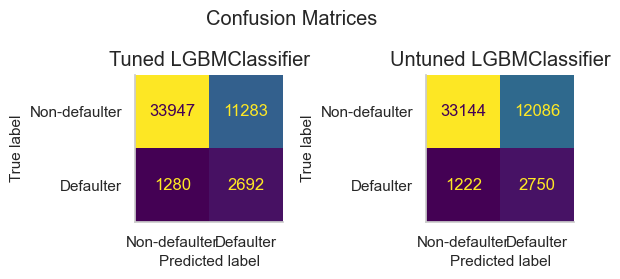

In [18]:
refit = False
if refit:
    lgbm_tuned = instantiate_lightgbm(best_trial)
    lgbm_tuned.set_params(
        n_estimators=n_estimators,
        early_stopping_rounds=None,
    )
    lgbm_tuned.fit(X_train_sub, y_train_sub)
    joblib.dump(lgbm_tuned, "./job_files/tuned_100model_sub.joblib")
    lgbm_untuned = LGBMClassifier(
        verbose=-1, random_state=42, class_weight="balanced", n_jobs=-1
    )
    lgbm_untuned.fit(X_train_sub, y_train_sub)
    joblib.dump(lgbm_untuned, "./job_files/untuned_100model_sub.joblib")
else:
    lgbm_tuned = joblib.load("./job_files/tuned_100model_sub.joblib")
    lgbm_untuned = joblib.load("./job_files/untuned_100model_sub.joblib")
res_df, _ = custom_model.score_binary_fitted_classifiers(
    ["Tuned LGBMClassifier", "Untuned LGBMClassifier"],
    [lgbm_tuned, lgbm_untuned],
    X=X_val,
    y=y_val,
    labels=["Non-defaulter", "Defaulter"],
)

The threshold of the classifier can be select to better represent business needs and favor recall or precision.

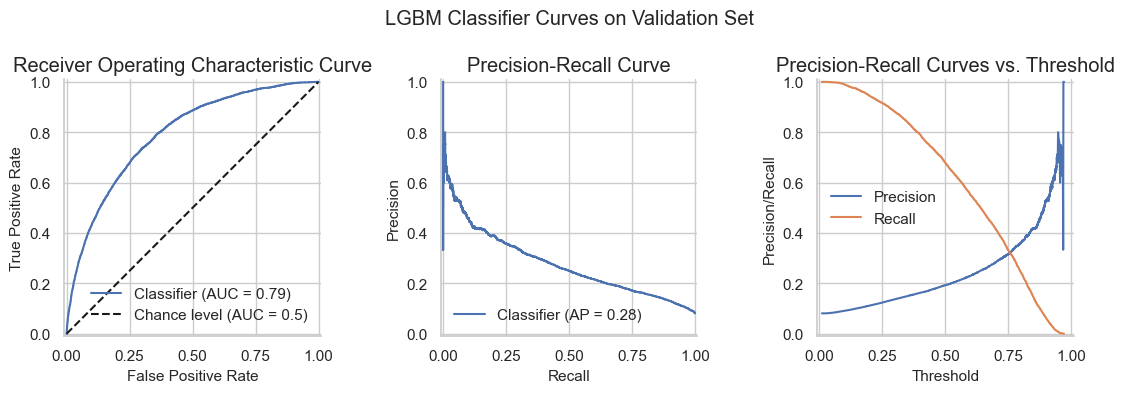

In [19]:
fig = custom_model.draw_fitted_classifier_curves(
    lgbm_tuned,
    X_val,
    y_val,
    title="LGBM Classifier Curves on Validation Set",
    size=(12, 4),
)
plt.savefig("./img/curves.png", bbox_inches="tight")
fig.show()

Threshold tuning is performed in order to maximize total gain. For this reason, it is assumed that all credits are taken in the same currency, that defaulters do not repay credit at all, and that average profit of credits is 10 percent. Cost matrix is built using average loan amount, and thus, all credits are treated equally.  

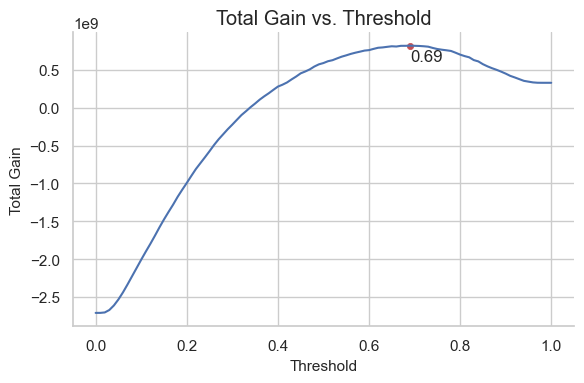

In [20]:
def total_sum(real: Any, proba: Any, th: float, cost_mx: Any) -> float:
    """Multiply confusion matrix by cost matrix for defined threshold and
    return overall sum of the resulting matrix."""
    cm = confusion_matrix(real, (proba[:, 1] >= th).astype(int))
    return sum(sum(cm * cost_mx))


avg_credit = appls_train["AMT_CREDIT"].mean()
profit_share = 0.1
cost_matrix = np.array([
    [avg_credit * profit_share, -avg_credit * profit_share],
    [-avg_credit, 0],
])
thresholds = [i / 100 for i in range(0, 101)]
total_gain = []
y_proba = lgbm_tuned.predict_proba(X_val)
for i in thresholds:
    total_gain.append(total_sum(y_val, y_proba, i, cost_matrix))
optimal_th = thresholds[argmax(total_gain)]
ax = sns.lineplot(x=thresholds, y=total_gain)
plt.scatter(x=optimal_th, y=max(total_gain), c="r", s=20)
ax.text(optimal_th, max(total_gain) * 0.75, f"{optimal_th}")
ax.set(xlabel="Threshold", ylabel="Total Gain")
plt.title("Total Gain vs. Threshold")
plt.savefig("./img/business_metric.png", bbox_inches="tight")
plt.show()

Using cost function, it is estimated that the optimal decision threshold to maximize the gain is 0.69.

In [21]:
print(
    "Default probability threshold yields gain of"
    f" {round(total_sum(y_val, y_proba, 0.5, cost_matrix) / 1e6)} mln."
    " \nOptimized probability threshold yields gain of"
    f" {round(total_sum(y_val, y_proba, optimal_th, cost_matrix) / 1e6)} mln."
)

Default probability threshold yields gain of 591 mln. 
Optimized probability threshold yields gain of 820 mln.


A tuned threshold results in much lower recall. This means that it might be favorable to give out credits even to possible defaulters because profits from non-defaulters, which could have been lost due to a more conservative threshold, compensate for the non-returned credits by defaulters.

,AUC,Average Precision,Recall,Precision,Accuracy,Balanced Accuracy,F1,F-beta,MCC
LGBMClassifier,0.792,0.278,0.678,0.193,0.745,0.714,0.300,0.451,0.259
Tuned-Threshold LGBMClassifier,0.792,0.278,0.431,0.277,0.863,0.666,0.337,0.388,0.273


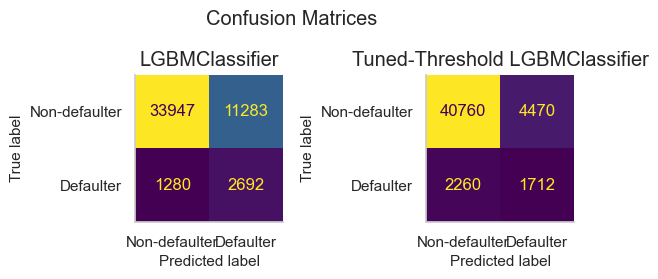

In [22]:
refit = False
if refit:
    lgbm_tuned_th = Thresholder(lgbm_tuned, threshold=optimal_th, refit=False)
    lgbm_tuned_th.fit(X_train_sub, y_train_sub)
    joblib.dump(lgbm_tuned_th, "./job_files/tuned_thresh_100model_sub.joblib")
else:
    lgbm_tuned_th = joblib.load("./job_files/tuned_thresh_100model_sub.joblib")
res_df, _ = custom_model.score_binary_fitted_classifiers(
    ["LGBMClassifier", "Tuned-Threshold LGBMClassifier"],
    [lgbm_tuned, lgbm_tuned_th],
    X=X_val,
    y=y_val,
    labels=["Non-defaulter", "Defaulter"],
)

### 6.2. <a id='toc6_2_'></a>Test Set     [&#8593;](#toc0_)

ROC AUC on test set is slightly lower compared to validation set (0.789 vs. 0.792). However, the result is good and does not indicate overfitting on validation set.

,AUC,Average Precision,Recall,Precision,Accuracy,Balanced Accuracy,F1,F-beta,MCC
LGBMClassifier,0.789,0.278,0.761,0.170,0.681,0.718,0.278,0.449,0.247
Tuned-Threshold LGBMClassifier,0.789,0.278,0.477,0.267,0.852,0.681,0.342,0.412,0.281


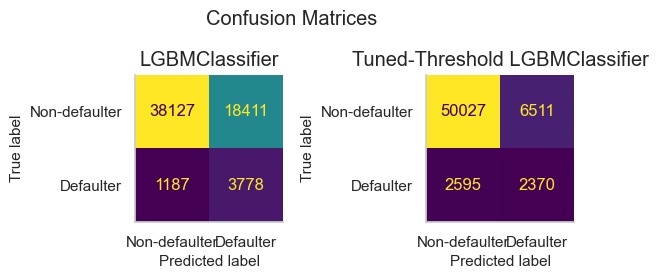

In [23]:
refit = False
if refit:
    lgbm_tuned = instantiate_lightgbm(best_trial)
    lgbm_tuned.set_params(
        n_estimators=n_estimators,
        early_stopping_rounds=None,
    )
    lgbm_untuned = LGBMClassifier(
        verbose=-1, random_state=42, class_weight="balanced", n_jobs=-1
    )
    X_train, _, y_train, _ = split_data(full_df_train, idx_train, [])
    X_test, _, y_test, _ = split_data(full_df_test, idx_test, [])
    X_train = preprocess_pipe.fit_transform(X_train, y_train)
    joblib.dump(preprocess_pipe, "./job_files/final_preprocess_pipe.joblib")
    X_train.to_csv("./data_preprocessed/X_train_preprocessed.csv")
    y_train.to_csv("./data_preprocessed/y_train.csv")
    X_test = preprocess_pipe.transform(X_test)
    X_test.to_csv("./data_preprocessed/X_test_preprocessed.csv")
    y_test.to_csv("./data_preprocessed/y_test.csv")
    lgbm_tuned.fit(X_train, y_train)
    joblib.dump(lgbm_tuned, "./job_files/tuned_100model_full.joblib")
    lgbm_tuned_th = Thresholder(lgbm_tuned, threshold=optimal_th, refit=False)
    lgbm_tuned_th.fit(X_train, y_train)
    joblib.dump(lgbm_tuned_th, "./job_files/tuned_thresh_100model_full.joblib")
else:
    lgbm_tuned = joblib.load("./job_files/tuned_100model_full.joblib")
    lgbm_tuned_th = joblib.load(
        "./job_files/tuned_thresh_100model_full.joblib"
    )
    X_test = pd.read_csv(
        "./data_preprocessed/X_test_preprocessed.csv", index_col=0
    )
    y_test = pd.read_csv("./data_preprocessed/y_test.csv", index_col=0)
res_df, fig = custom_model.score_binary_fitted_classifiers(
    ["LGBMClassifier", "Tuned-Threshold LGBMClassifier"],
    [lgbm_tuned, lgbm_tuned_th],
    X=X_test,
    y=y_test,
    labels=["Non-defaulter", "Defaulter"],
)
plt.savefig("./img/matrices.png", bbox_inches="tight")
plt.show()

In case of the test set, tuned threshold also helps to increase the total gain.

In [24]:
y_proba = lgbm_tuned.predict_proba(X_test)
print(
    "Default probability threshold yields gain of"
    f" {round(total_sum(y_test, y_proba, 0.5, cost_matrix) / 1e6)} mln."
    " \nOptimized probability threshold yields gain of"
    f" {round(total_sum(y_test, y_proba, optimal_th, cost_matrix) / 1e6)} mln."
)

Default probability threshold yields gain of 470 mln. 
Optimized probability threshold yields gain of 1022 mln.


Performance curves of the LGBM classifier on the test set is again very similar to those received on validation set.

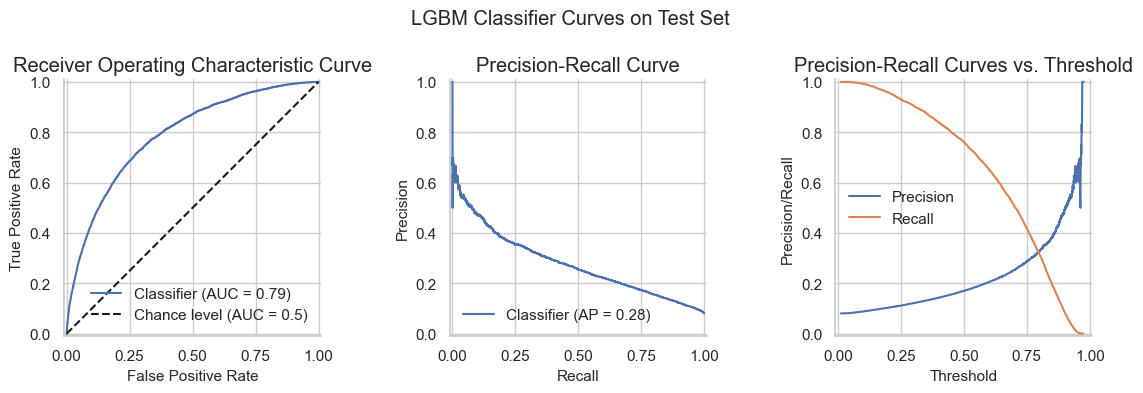

In [25]:
fig = custom_model.draw_fitted_classifier_curves(
    lgbm_tuned,
    X_test,
    y_test,
    title="LGBM Classifier Curves on Test Set",
    size=(12, 4),
)
fig.show()

### 6.3. <a id='toc6_3_'></a>Model Interpretation  [&#8593;](#toc0_)

In splits, LGBM uses features related to amounts, external sources, days defining age and employment length as well as behavior of similar applicants. Among top features there are engineered features from bureau as well as previous applications tables.

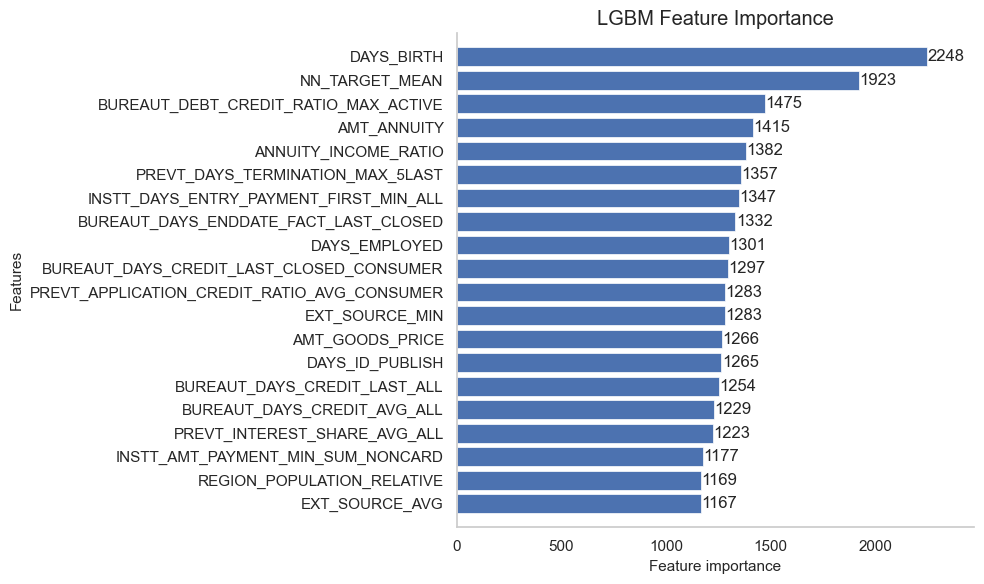

In [26]:
lgbm.plot_importance(
    lgbm_tuned,
    max_num_features=20,
    height=0.8,
    grid=False,
    figsize=(10, 6),
)
plt.title("LGBM Feature Importance")
plt.show()

Analyzing the SHAP values from the final model, it is obvious that the most import feature to explain decisions is target mean of the closest 500 neighbors based on external sources and credit/annuity ratio. Other top features are also from the main application table. However, there are a couple of aggregated features from other tables among the top 20 features.

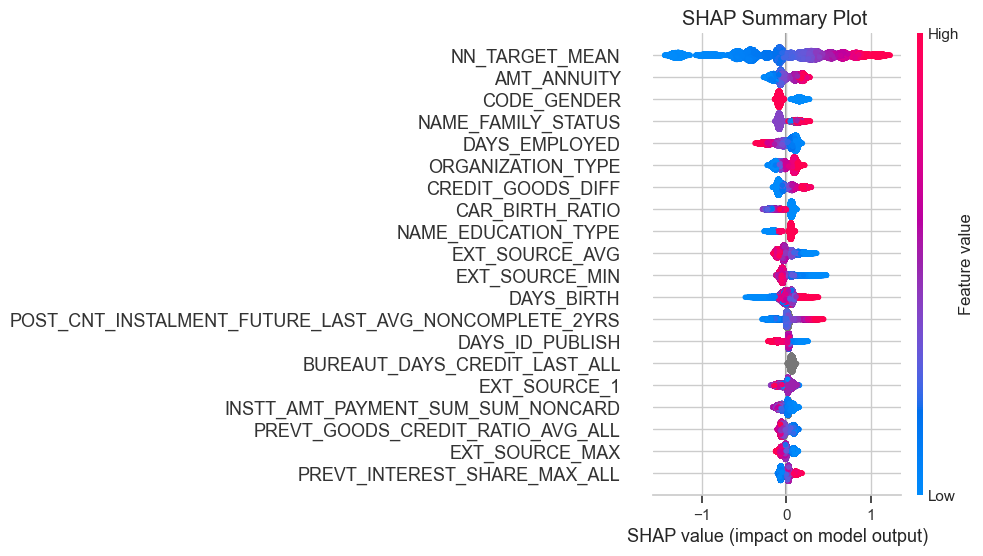

In [27]:
refit = False
if refit:
    explainer = shap.TreeExplainer(lgbm_tuned)
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(
        shap_values[1],
        X_test,
        show=False,
        plot_size=(4, 6),
    )
    plt.title("SHAP Summary Plot ")
    plt.savefig("./output/SHAP_tuned.png", bbox_inches="tight")
    plt.show()
else:
    display(Image("./output/SHAP_tuned.png"))

## 7. <a id='toc7_'></a>Model Deployment  [&#8593;](#toc0_)

Credit default risk prediction model is a part of Credit Default Risk Prediction Service deployed at GCP. It can be reached via link at: https://home-credit-fastapi-r5bhc3nhna-lm.a.run.app/app/. The model provides predictions on the preprocessed data. To test the model, a small example dataset can be used.

In [28]:
X_test.head(30).to_csv("./X_test_example.csv")

Model is deployed using Gradio interface and allows to select row from the dataset for prediction. It is allowed to use different prediction threshold, which may better reflect business needs.

## 8. <a id='toc8_'></a>Recommendations [&#8593;](#toc0_)

* Fully automating default risk prediction is a difficult task, and thus, expert knowledge should be used to make a final decision on accepting credit applications.
* Bearing in mind that applicants come from different regions, it might be useful to account for differences in incoming data.
* Data coming from the main application is the most important in predicting default risk. Without any feature engineering and additional data, cross-validated ROC AUC is 0.751. Using feature engineering and additional data sources, it is possible to increase the metric to 0.789.
* It is important to choose decision threshold wisely to optimize for the relevant business metric.
* Identifying the most similar applications (closest neighbors in terms of data from external sources and credit/annuity ratio) is the strongest predictor of default risk.
* The model best performing in default prediction is the LGBM classifier. However, such a classic architecture as logistic regression can also be used for the task with comparable performance.

## 9. <a id='toc9_'></a>Suggestions for Improvements [&#8593;](#toc0_)

* Different models, as well as missing value imputation and categorical feature encoding techniques, could be tuned to estimate their full potential. Also, other approaches for feature selection could be used to ensure the optimal model performance.
* While tuning the decision threshold to maximize the business metric, individual credits could be weighted based on their amounts. However, it is not possible in this task because currencies are not provided, and thus credits are not directly comparable.
* It would be valuable to check if the model performs without bias for different types of applicants (e.g., based on their location, gender, age, whether they are applying for the first time).
* The deployed model could include a preprocessing and feature engineering pipeline to ensure easier scaling; however, it would make the submission of the data much more complicated.